<a href="https://colab.research.google.com/github/utility001/cifar-10/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big picture

Practice training a deep neural network on the CIFAR10 image dataset:

a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function.

b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with tf.keras.datasets.cifar10.load_data(). 
The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. 
Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

c. Now try adding batch normalization and compare the learning curves: is it converging faster than before? Does it produce a bettermodel? How does it affect training speed?

d. Try replacing batch normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout.

f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

# Ingest

In [ ]:
# !pip install tensorflow

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [2]:
# cifar_10 details
tf.keras.datasets.cifar10.load_data?

Signature: tf.keras.datasets.cifar10.load_data()
Docstring:
Loads the CIFAR10 dataset.

This is a dataset of 50,000 32x32 color training images and 10,000 test
images, labeled over 10 categories. See more info at the
[CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html).

The classes are:

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

**`x_train`**: `uint8` NumPy array of grayscale image data with shapes
  `(50000, 32, 32, 3)`, containing the training data. Pixel values range
  from 0 to 255.

**`y_train`**: `uint8` NumPy array of labels (integers in range 0-9)
  with shape `(50000, 1)` for the training data.

**`x_test`**: `uint8` NumPy array of grayscale image d

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    random_state=42,
    test_size=10_000,
    shuffle=True,
    stratify=y_train_full
)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
y_train.shape, y_val.shape, y_test.shape

((40000, 1), (10000, 1), (10000, 1))

In [8]:
X_train[0].shape, X_train[0].min(), X_train[3].max()

((32, 32, 3), 0, 244)

In [9]:
X_train.max()

255

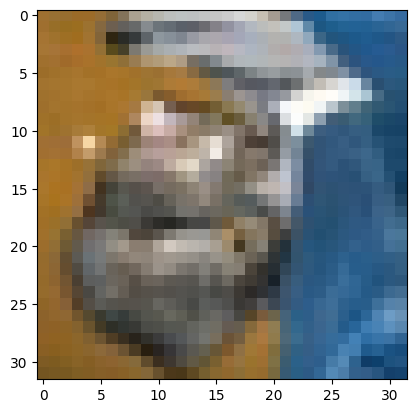

In [22]:
plt.imshow(np.transpose(X_test[0], (1, 0, 2)), interpolation='nearest')

ModuleNotFoundError: No module named 'skimage'

In [ ]:
def counts(target, name):
    value_counts = pd.Series(target, name=name).value_counts()
    percentages = (value_counts/len(target)) * 100

    vcs = pd.DataFrame({
        f"count {name}": value_counts,
        f"percentages {name}": percentages
    })
    return vcs